In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('..')
sys.path.append('../src')
import os
from os.path import join as oj
import numpy as np
from copy import deepcopy
import pandas as pd
import data
# import models
from math import ceil
# from style import *
import dvu
import pickle as pkl
# from style import *
import viz
from viz import *
import config
outcome_def = 'y_consec_thresh'

In [3]:
# df = data.get_data(use_processed=True) #, dset='orig') # all_data=True
df = data.get_data(dset='clath_aux_dynamin')
dfv = df[~(df.short | df.long | df.hotspots)]
dfv = dfv[dfv.lifetime > 15] # only keep hard tracks
# dfv = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots

In [4]:
dft = dfv[dfv.cell_num.isin(config.DSETS['clath_aux_dynamin']['test'])] # exclude held-out test data

**plot curves (for intro fig)**

In [ ]:
R, C = 2, 2
plt.figure(facecolor='w', figsize=(5, 5))
viz.plot_curves(dfv.iloc[[0, 1, 48, 37]], extra_key='Z', extra_key_label='Dynamin',
                R=R, C=R, fig=True, ylim_constant=True, legend=False, hline=False)
plt.subplot(R, C, 2)
plt.legend(fontsize=20, frameon=False, handlelength=0.7)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim((0, 60))
viz.savefig('intro_curves')

**plot curves (for examples fig)**

In [ ]:
plt.figure(figsize=(3, 8))
R, C = 3, 1
dfv_minus = dfv[dfv[outcome_def] == 0].sort_values('X_max')
viz.plot_curves(dfv_minus, R=R, C=C, fig=True, extra_key='Z',
                ylim_constant=True, legend=False, hline=False)
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.subplot(R, C, 1)
# plt.legend(fontsize=18)
r = dfv_minus.iloc[0]
plt.text(len(r.X), r.X[-1], 'Clathrin', color=cr, fontsize=20)
# plt.title('A', loc='left', fontweight='bold')
plt.text(len(r.Z), 50, 'Dynamin', color='gray', fontsize=20)
plt.text(len(r.Y), 0, 'Auxilin', color=cg, fontsize=20)
plt.title('Abortive')
plt.tight_layout()
viz.savefig('traces_minus')
# plt.savefig('figs/fig_traces_minus.pdf')

plt.figure(figsize=(3, 8))
dfv_plus = dfv[(dfv[outcome_def] == 1) & (dfv.lifetime < 50)].sort_values('Y_max', ascending=False)
viz.plot_curves(dfv_plus, R=R, C=C, fig=True, extra_key='Z',
                ylim_constant=True, legend=False, hline=False)
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.subplot(R, C, 1)
# plt.title('B', loc='left', fontweight='bold')
plt.title('Valid')
plt.tight_layout()
viz.savefig('traces_plus')
# plt.savefig('figs/fig_traces_plus.pdf')

## extract and plot videos

In [151]:
fns = [209962, 210547, 253794, 209359, 256669, 204176, 209253, 206666,
       252098, 222344, 229111, 206112, 252035, 252672, 230395, 229331,
       226297, 209281, 257705, 208023, 206854, 209477, 217527, 252591,
       204267, 253593, 229049, 205411, 209870, 229007, 222420, 252157,
       226080, 230139, 206526, 258741]
fps = [232309, 212170, 244097, 243565, 248147, 239277, 233494, 213856,
       242676, 225190, 232900, 256935, 224046, 255998, 214766, 220311,
       235043, 247567, 245029, 254986, 246437, 258790, 228264, 212136,
       215418, 227764, 229344, 237565, 216122, 219854, 215393, 243758,
       252940, 234206, 225705, 249716]

In [180]:
videos = get_all_dynamin_videos(set(dfv_plus.cell_num))

In [249]:
event_type = 'valid'
dfv = {'abortive': dfv_minus, 'valid': dfv_plus}
videos = viz.get_dynamin_data_videos(dfv[event_type], 
                                     dfv[event_type].pid.values[:10],
                                     add_px=7)

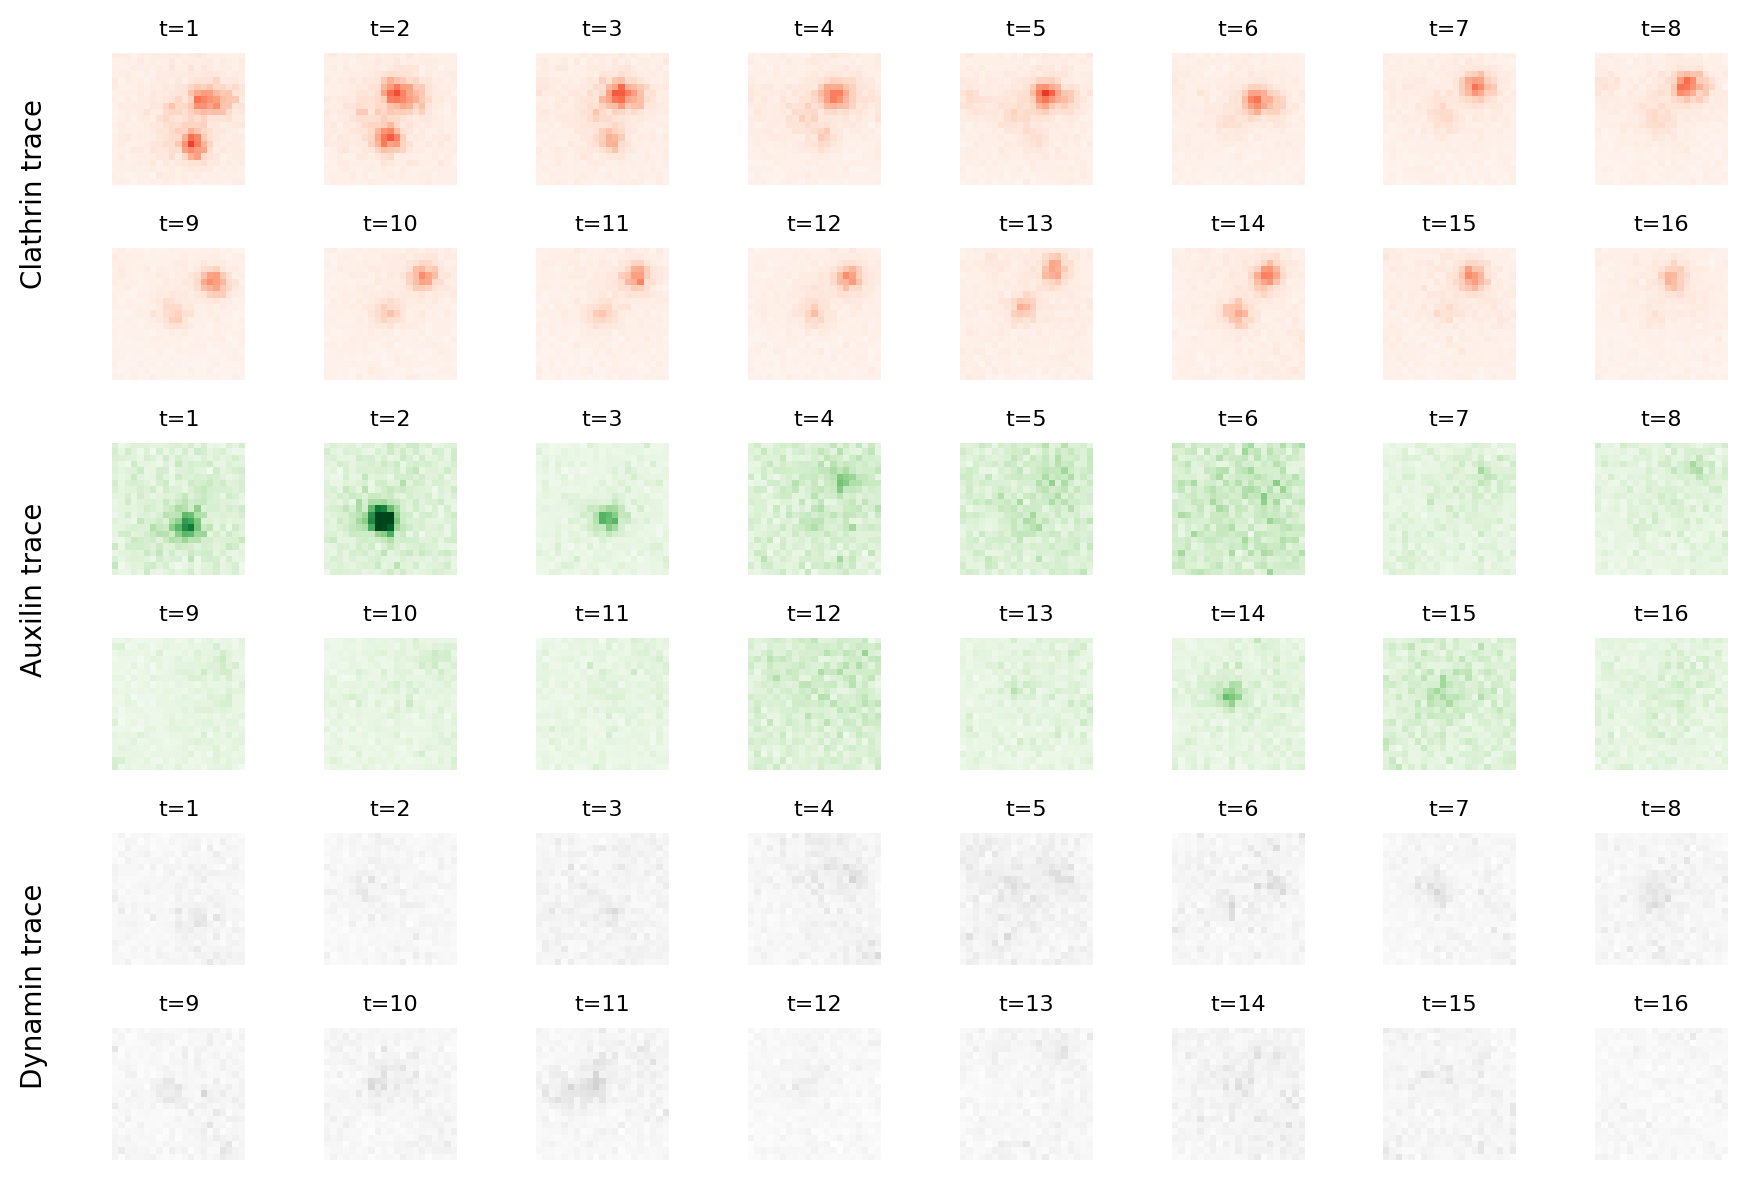

In [209]:
pid = dfv[event_type].pid.values[1]
#pid = fns[2]
n = len(videos[pid]['aux'])

fig = plt.figure(figsize=(9, 6), dpi=200)
cmaps = {'cla': 'Reds', 'aux': 'Greens', 'dyn': 'Greys'}
for k, m in enumerate(['cla', 'aux', 'dyn']):
    lt = len(videos[pid][m])
    for i in range(len(videos[pid][m])):
        ax = plt.subplot(6, int((lt + 1)/2), i + 1 + k*(2*int((lt + 1)/2)))
        ax.imshow(videos[pid][m][i], vmin=0, vmax=1, cmap=cmaps[m]) # Auxilin
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(label=f't={i + 1}', fontsize=8)

fig.text(0, 0.83, 'Clathrin trace', va='center', rotation='vertical')
fig.text(0, 0.5, 'Auxilin trace', va='center', rotation='vertical')
fig.text(0, 0.17, 'Dynamin trace', va='center', rotation='vertical')
plt.tight_layout()

#viz.savefig(f'{event_type}_example')

## make grid version of figs¶

### grid of curves

(0, 39)
(0, 39)
(0, 39)
(0, 39)
(0, 39)
(0, 39)


<ipython-input-23-549cc9a4c9c7>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, 6)


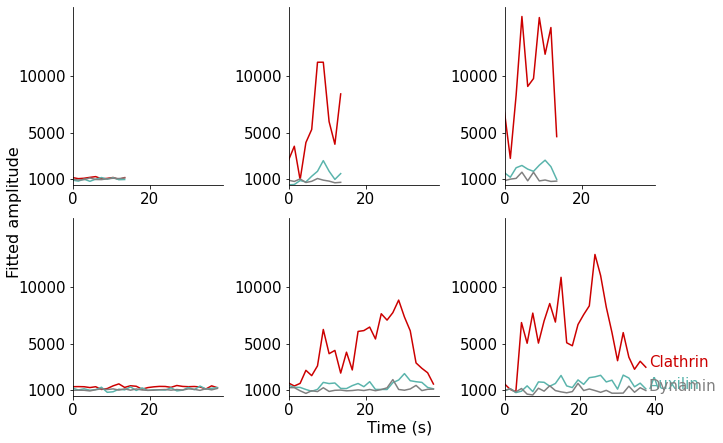

In [23]:
d = pd.DataFrame()
for l in [39, 15][::-1]:
    ds = df[df.lifetime == l].sort_values('X_max')
    d = d.append(ds.iloc[[10, -100, -30]])

# print(d)
fig = plt.figure(figsize=(10, 6))
viz.plot_curves(d, R=2, C=3, hline=False,
                xlim_constant=True,
                ylim_constant=True,
                legend=False,
                extra_key='Z',
                extra_key_label='Dynamin',
                xlim=(0, 39),
                ylim=(-500, 15000),
                yticks=[1000, 5000, 10000],
                #yticklabels=["$0$", "$10^4$"],                
                fig=fig)
fig.text(0, 0.5, 'Fitted amplitude', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 0, 'Time (s)', va='center', fontsize=16)
plt.subplot(2, 3, 6)
dvu.line_legend()
plt.xlim((0, 40))

#plt.subplot(2, 2, 4)
#plt.ylabel('Fitted amplitude')

#plt.subplot(2, 2, 4)
#plt.xlabel('Lifetime')


viz.savefig('intro_grid')
plt.show()

In [24]:
add_px = 7
videos = viz.get_dynamin_data_videos(d, d.pid.values, add_px=add_px)

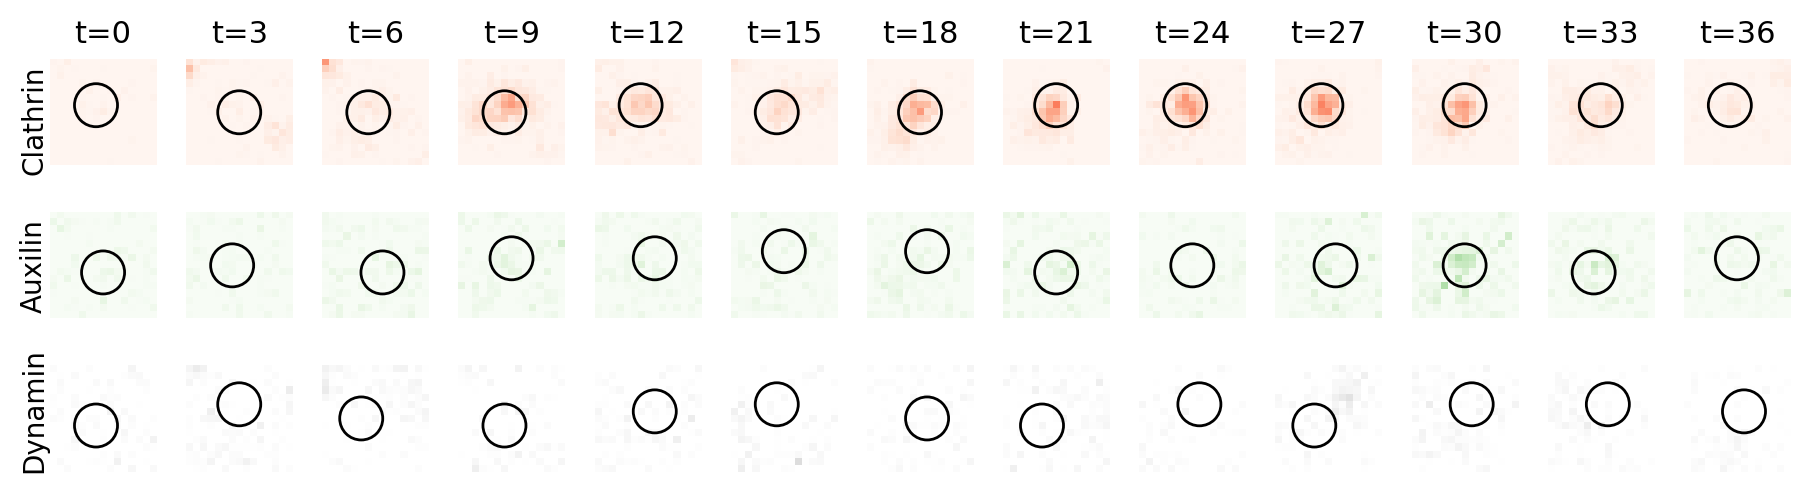

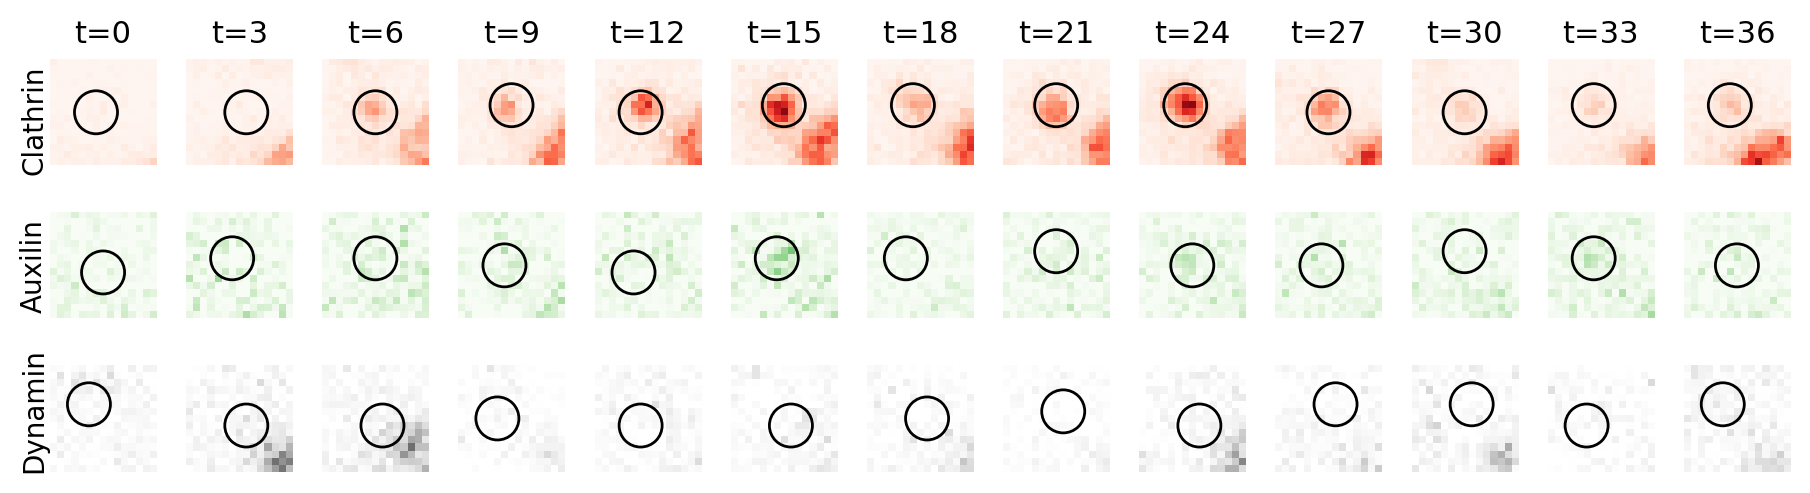

In [26]:
for ex_num, name in zip([4, 5], ['abortive', 'valid']):
    pid = d.pid.values[ex_num]
    n = len(videos[pid]['aux'])
    #n = n - n % 2
    subsample = 2
    nsub = ceil(n / subsample)

    fig = plt.figure(figsize=(9, 3.3), dpi=200, facecolor='w')
    cmaps = {'cla': 'Reds', 'aux': 'Greens', 'dyn': 'Greys'}
    for k, m in enumerate(['cla', 'aux', 'dyn']):
        for j, i in enumerate(range(n)[::subsample]):
            ax = plt.subplot(3, nsub, j + 1 + nsub * k)
            ax.imshow(videos[pid][m][i], vmin=0, vmax=1, cmap=cmaps[m]) # Auxilin
            if k <= 2:
                max_amp = -10
                l1_max, l2_max = 0, 0
                for l1 in range(add_px - 2, add_px + 2):
                    for l2 in range(add_px - 2, add_px + 2):
                        if np.sum(videos[pid][m][i][(l1 - 2):(l1 + 3),:][:,(l2 - 2):(l2 + 3)]) > max_amp:
                            max_amp = np.sum(videos[pid][m][i][(l1 - 2):(l1 + 3),:][:,(l2 - 2):(l2 + 3)])
                            l1_max, l2_max = l1, l2
                ax.scatter(l1_max, l2_max, s=240, facecolors='none', edgecolors='k')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            if k == 0:
                ax.set_title(label=f't={int(1.5 * i)}', fontsize=11)
            
    fig.text(0, 0.72, 'Clathrin', va='center', rotation='vertical')
    fig.text(0, 0.5, 'Auxilin', va='center', rotation='vertical')
    fig.text(0, 0.28, 'Dynamin', va='center', rotation='vertical')
    plt.tight_layout()

    viz.savefig(f'grid_{name}')

# viz hists

total events 210587


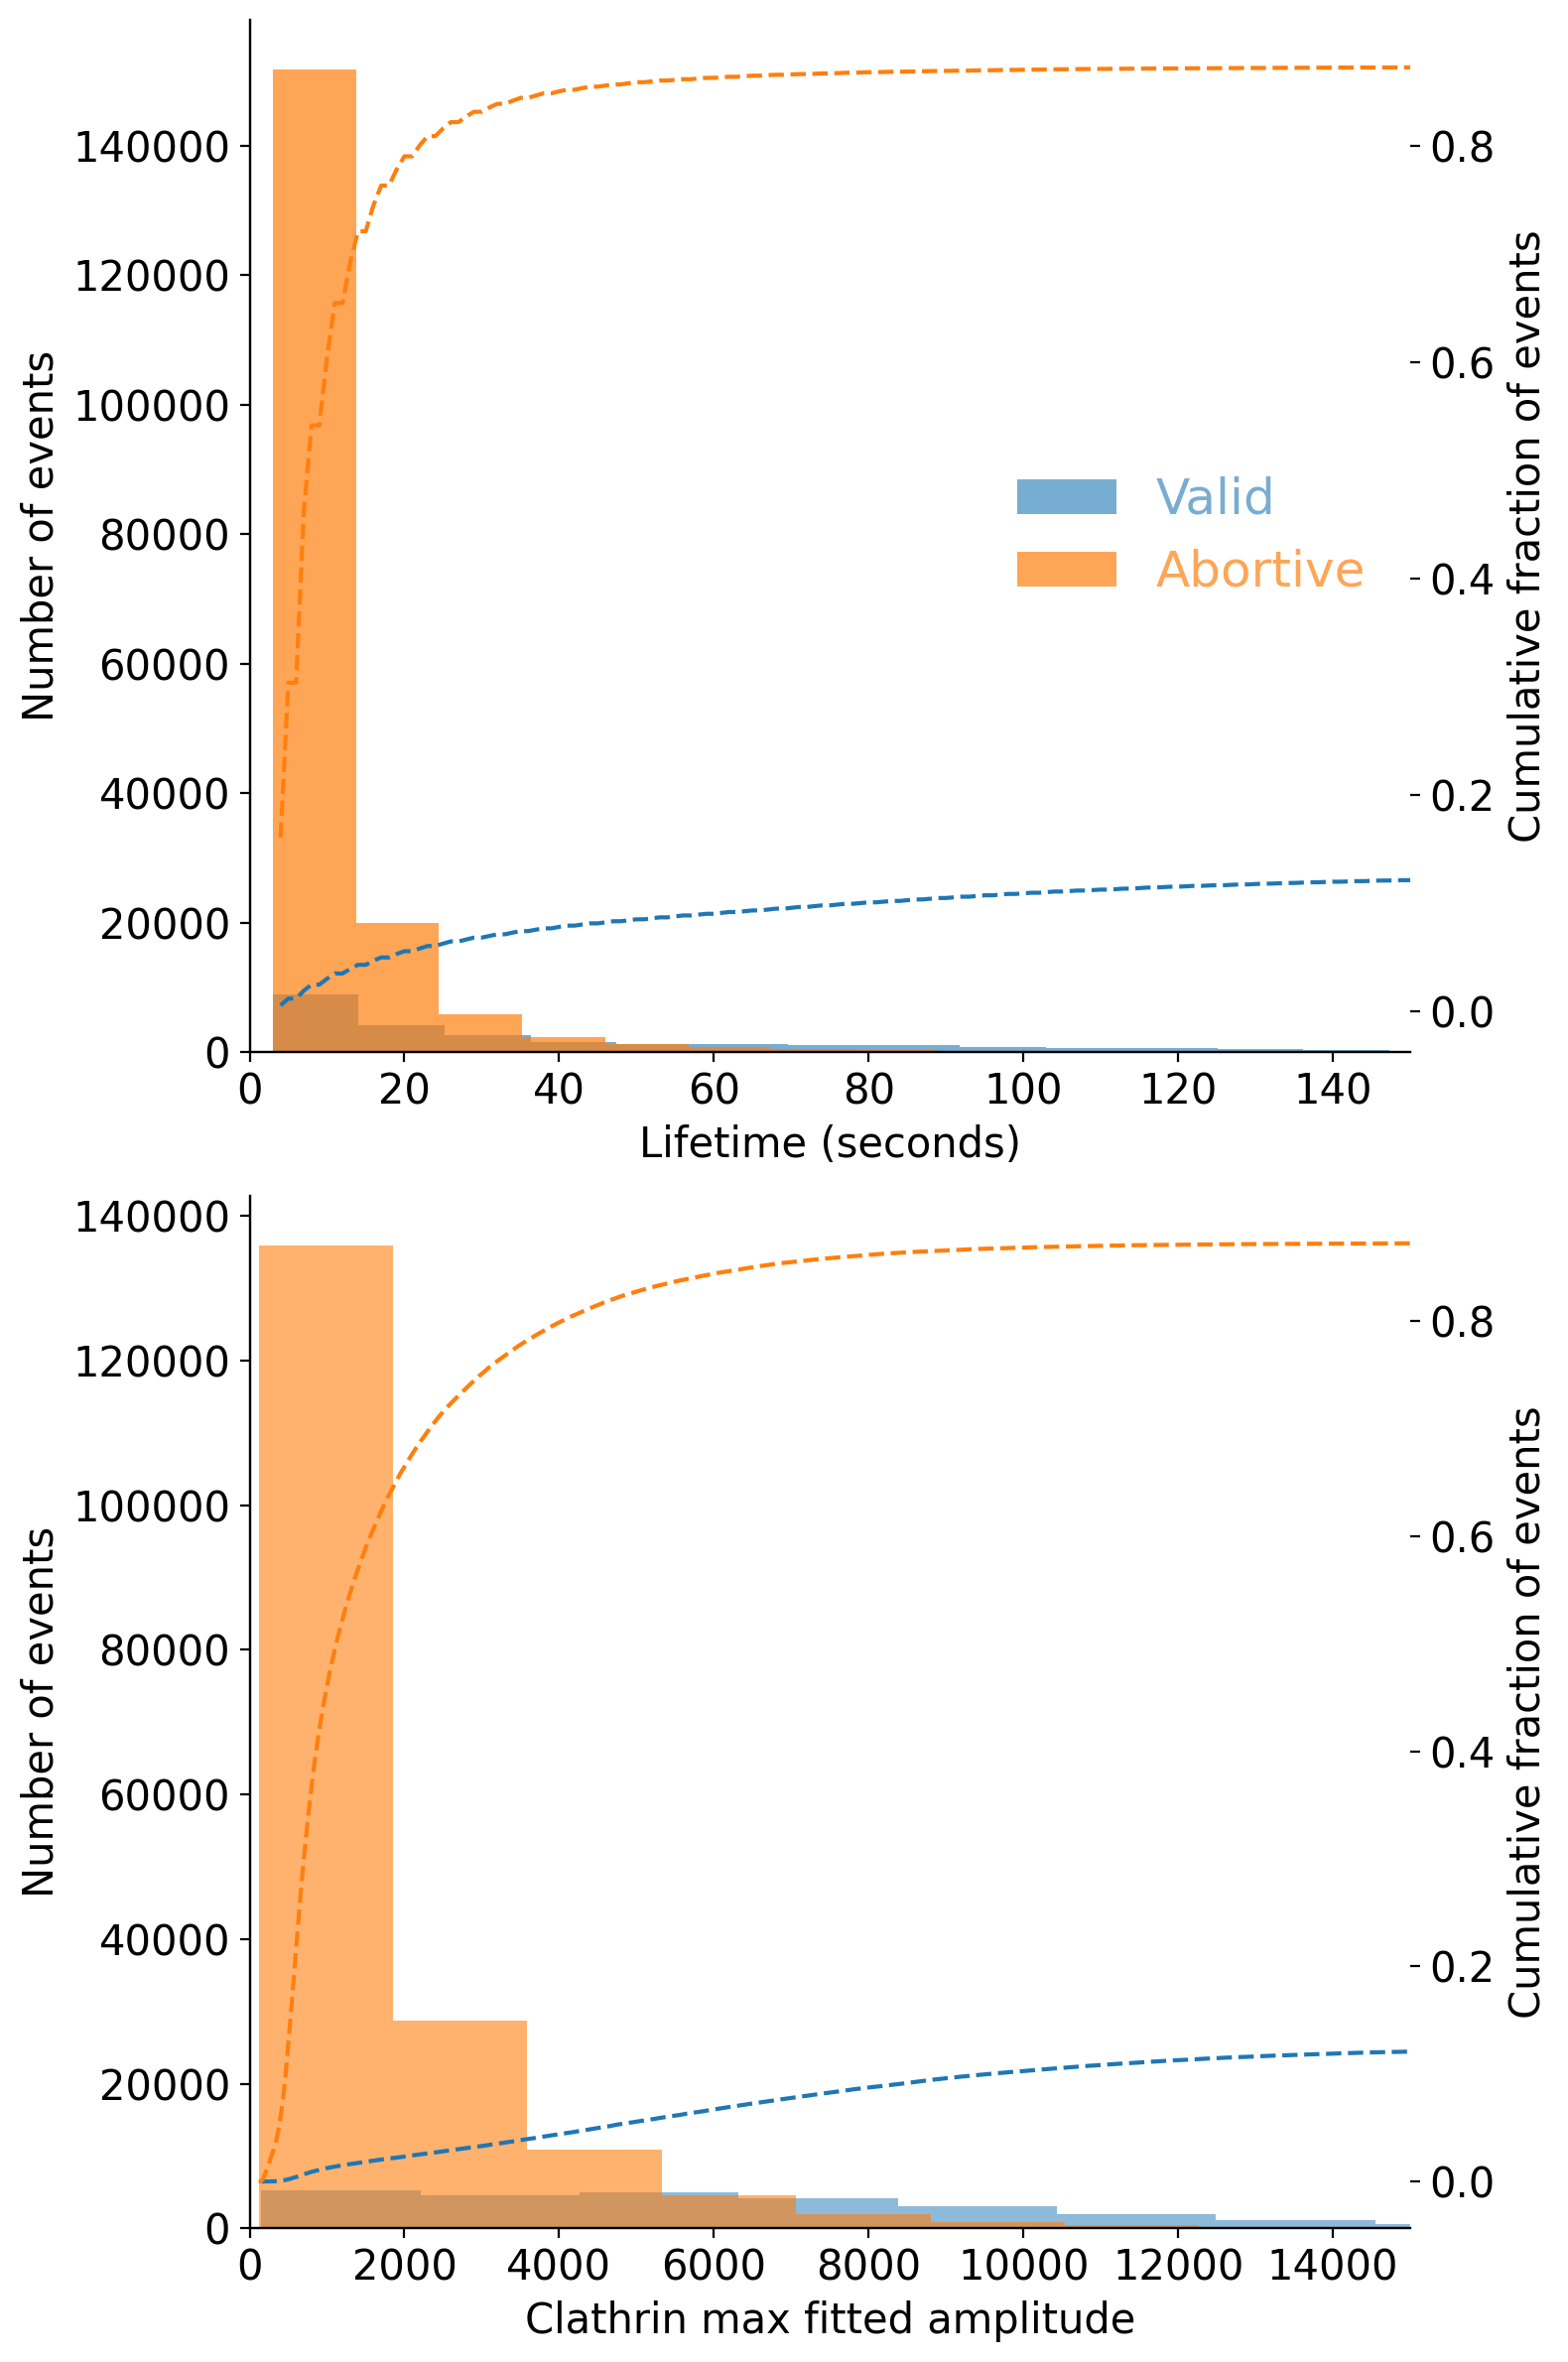

In [8]:
outcome = df[outcome_def]
R, C = 2, 1
dval = df[outcome == 1]
da = df[outcome == 0]

def cdf(x):
    x = np.array(sorted(x))
    nums = np.arange(np.min(x), np.max(x)) + 1
    return nums, np.array([np.sum(x < i)
                           for i in nums])

plt.figure(figsize=(8, 12), dpi=200)
ax = plt.subplot(R, C, 1)
# plt.title('All events')
ax.hist(dval['lifetime'], label='Valid', alpha=0.6, color=cb, bins=25, density=False)
ax.hist(da['lifetime'], label='Abortive', alpha=0.7, color=co, bins=25, density=False)
ax.set_ylabel('Number of events')
print('total events', df.shape[0])
ax2 = ax.twinx()
x, cy = cdf(dval['lifetime'])
ax2.plot(x, cy/df.shape[0], '--', alpha=1, color=cb)


x, cy = cdf(da['lifetime'])
ax2.plot(x, cy/df.shape[0], '--', alpha=1, color=co)
ax2.set_xlim([0, 150])
ax.set_xlabel('Lifetime (seconds)')
ax2.set_ylabel('Cumulative fraction of events')
ax.legend(fontsize=18, frameon=False, loc='center right', labelcolor='linecolor')


ax = plt.subplot(R, C, 2)
# plt.title('All events')
ax.hist(dval['X_max'], label='Valid', alpha=0.5, color=cb, bins=25, density=False)
ax.hist(da['X_max'], label='Abortive', alpha=0.6, color=co, bins=25, density=False)
ax.set_ylabel('Number of events')
ax2 = ax.twinx()
ax2.set_xlim([0, 15000])

x, cy = cdf(dval['X_max'])
ax2.plot(x, cy/df.shape[0], '--', alpha=1, color=cb)

x, cy = cdf(da['X_max'])
ax2.plot(x, cy/df.shape[0], '--', alpha=1, color=co)
ax.set_xlabel('Clathrin max fitted amplitude')
ax2.set_ylabel('Cumulative fraction of events')
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# ax.legend(fontsize=18, frameon=False, loc='center right')

'''
plt.subplot(R, C, 2)
plt.hist(dval['X_max'], label='Valid', alpha=1, color=cb, bins=5)
plt.hist(da['X_max'], label='Abortive', alpha=0.7, color=co, bins=5)
plt.xlabel('Clathrin max amplitude')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')

plt.subplot(R, C, 3)
plt.hist(df['fall'][outcome == 1], label='aux+', alpha=1, color=cb, bins=25)
plt.hist(df['fall'][outcome == 0], label='aux-', alpha=0.7, color=cr, bins=25)
plt.xlabel('Fall')
plt.ylabel('Count')
'''
plt.tight_layout()
viz.savefig('hists')
# plt.savefig('figs/fig_hists.pdf')
plt.show()

# dset sizes

In [ ]:
viz.print_metadata(acc=None, metadata_file='processed/metadata_clath_aux.pkl')

In [85]:
df_test = df[df.cell_num.isin(config.SPLITS['orig']['test'])]

In [88]:
print('valid', df_test.shape[0], df_test[outcome_def].sum())

valid 2497 561.0


In [91]:
d = df_test[~df_test['short'] & ~df_test['long']]
print('difficult', d.shape[0], d[outcome_def].sum())

difficult 1045 469.0
